In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rosbag
import pymap3d as pm
import numba as nb

from scipy.integrate import cumtrapz
from scipy.signal import savgol_filter
%matplotlib inline

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [2]:
def wrap_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

@nb.njit()
def to_euler(x, y, z, w):
    """Dari Coursera: Return as xyz (roll pitch yaw) Euler angles."""
    roll = np.arctan2(2 * (w * x + y * z), 1 - 2 * (x**2 + y**2))
    pitch = np.arcsin(2 * (w * y - z * x))
    yaw = np.arctan2(2 * (w * z + x * y), 1 - 2 * (y**2 + z**2))
    return np.array([roll, pitch, yaw])
# Compile the to_euler
_ = to_euler(1.5352300785980803e-15, -1.3393747145983517e-15, -0.7692164172827881, 0.638988343698562)

def calculate_s(wp_x, wp_y):
    s = np.zeros(wp_x.shape[0])
    for i in range(1, s.shape[0]):
        s[i] = s[i-1] + np.sqrt((wp_x[i] - wp_x[i-1])**2 + (wp_y[i] - wp_y[i-1])**2)
    return s

In [3]:
bag = rosbag.Bag('data_fixed/belok_1.bag')
# print(bag)

# CONTROL DATA

In [4]:
cs_t = []
cs_action_throttle = []
cs_action_steer = []
cs_error_lateral = []
cs_error_yaw = []
cs_actual_x = []
cs_actual_y = []
cs_actual_yaw = []
cs_actual_speed = []
cs_ref_x = []
cs_ref_y = []
cs_ref_yaw = []
cs_ref_curvature = []
cs_wp_idx = []
for topic, msg, _ in bag.read_messages(topics=['/control_signal']):
    cs_t.append(msg.header.stamp.to_sec())
    cs_action_throttle.append(msg.action_throttle)
    cs_action_steer.append(msg.action_steer)
    cs_error_lateral.append(msg.error_lateral)
    cs_error_yaw.append(msg.error_yaw)
    cs_actual_x.append(msg.actual_x)
    cs_actual_y.append(msg.actual_y)
    cs_actual_yaw.append(msg.actual_yaw)
    cs_actual_speed.append(msg.actual_speed)
    cs_ref_x.append(msg.ref_x)
    cs_ref_y.append(msg.ref_y)
    cs_ref_yaw.append(msg.ref_yaw)
    cs_ref_curvature.append(msg.ref_curvature)
    cs_wp_idx.append(msg.wp_idx)
cs_t = np.array(cs_t)
cs_action_throttle = np.array(cs_action_throttle)
cs_action_steer = np.array(cs_action_steer)
cs_error_lateral = np.array(cs_error_lateral)
cs_error_yaw = np.array(cs_error_yaw)
cs_actual_x = np.array(cs_actual_x)
cs_actual_y = np.array(cs_actual_y)
cs_actual_yaw = np.array(cs_actual_yaw)
cs_actual_speed = np.array(cs_actual_speed)
cs_ref_x = np.array(cs_ref_x)
cs_ref_y = np.array(cs_ref_y)
cs_ref_yaw = np.array(cs_ref_yaw)
cs_ref_curvature = np.array(cs_ref_curvature)
cs_wp_idx = np.array(cs_wp_idx)

In [5]:
cs_actual_x.shape

(653,)

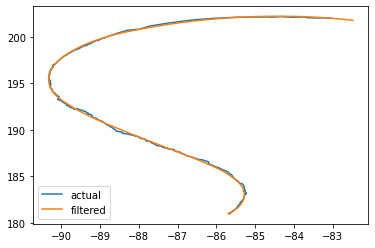

In [6]:
xf = savgol_filter(cs_actual_x, 201, 3)
yf = savgol_filter(cs_actual_y, 201, 3)
plt.plot(cs_actual_x, cs_actual_y, label='actual')
plt.plot(xf, yf, label='filtered')
plt.legend()
plt.show()

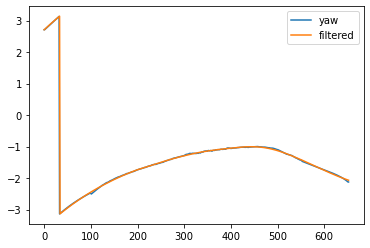

In [7]:
dxf = xf[2:] - xf[:-2]
dyf = yf[2:] - yf[:-2]
yaw = np.zeros_like(xf)
yaw[1:-1] = np.arctan2(dyf, dxf)
yaw[0] = yaw[1]
yaw[-1] = yaw[-2]
yawf = wrap_angle(savgol_filter(np.unwrap(yaw), 201, 3))
plt.plot(yaw, label='yaw')
plt.plot(yawf, label='filtered')
plt.legend()
plt.show()

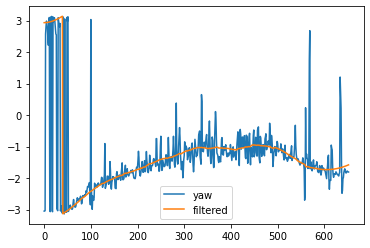

In [8]:
dx = cs_actual_x[2:] - cs_actual_x[:-2]
dy = cs_actual_y[2:] - cs_actual_y[:-2]
yaw = np.zeros_like(xf)
yaw[1:-1] = np.arctan2(dy, dx)
yaw[0] = yaw[1]
yaw[-1] = yaw[-2]
yawf = wrap_angle(savgol_filter(np.unwrap(yaw), 151, 3))
plt.plot(yaw, label='yaw')
plt.plot(yawf, label='filtered')
plt.legend()
plt.show()

# ANDROID IMU DATA

In [9]:
imu_t = []
imu_a = []
imu_w = []
imu_q = []
imu_rpy = []
for topic, msg, _ in bag.read_messages(topics=['/imu']):
    imu_t.append(msg.header.stamp.to_sec())
    acc = msg.linear_acceleration
    imu_a.append([acc.x, acc.y, acc.z])
    acc = msg.angular_velocity
    imu_w.append([acc.x, acc.y, acc.z])
    q = msg.orientation
    imu_q.append([q.x, q.y, q.z, q.w])
    imu_rpy.append(to_euler(q.x, q.y, q.z, q.w))
imu_t = np.array(imu_t)
imu_a = np.array(imu_a)
imu_w = np.array(imu_w)
imu_q = np.array(imu_q)
imu_rpy = np.array(imu_rpy)

# PERBANDINGAN

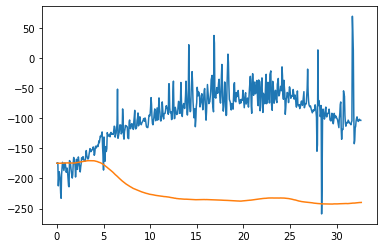

In [10]:
plt.plot(cs_t - cs_t[0], np.unwrap(yaw)*180/np.pi)
lim = 248
plt.plot(imu_t[lim:-1] - imu_t[lim], (np.unwrap(imu_rpy[:,-1])[lim:-1] + np.unwrap(yaw)[0] - np.unwrap(imu_rpy[:,-1])[lim])*180/np.pi)

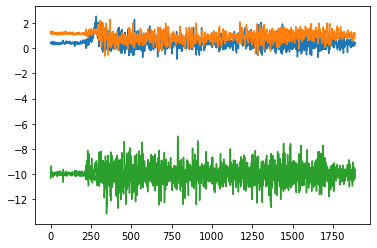

In [11]:
plt.plot(imu_a[:,:])

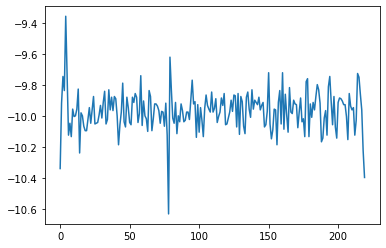

In [12]:
# plt.plot(imu_a[:220,0])
plt.plot(imu_a[:220,2])

In [13]:
vx = cumtrapz(imu_a[:,0] - np.mean(imu_a[:220,0]), imu_t, initial=0)
vy = cumtrapz(imu_a[:,1] - np.mean(imu_a[:220,1]), imu_t, initial=0)
vz = cumtrapz(imu_a[:,2] - np.mean(imu_a[:220,2]), imu_t, initial=0)

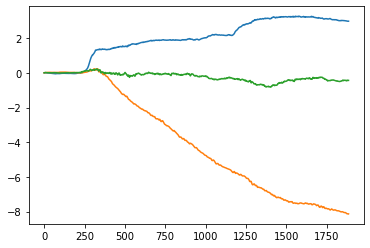

In [14]:
plt.plot(vx)
plt.plot(vy)
plt.plot(vz)

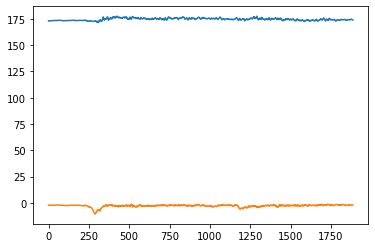

In [15]:
plt.plot(imu_rpy[:,0]*180/np.pi)
plt.plot(imu_rpy[:,1]*180/np.pi)